In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10  # output_size
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# TODO: define train set and test set
train_set = datasets.MNIST(root="./data",
                           train=True,
                           transform=ToTensor(),
                           download=True)

test_set = datasets.MNIST(root="./data",
                          train=False,
                          transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 124765062.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39860379.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44800747.53it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14848424.60it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# TODO: define dataloader for train and test
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=False)

In [4]:
# Fully connected neural network with one hidden layer
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()
        # Layers of the model
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        # Defining forward for the model
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)

        return out

In [13]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      # images = images.to(device)
      images = images.reshape(-1, 28*28).to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [14]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    images = images.reshape(-1, 28*28).to(device)
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [19]:
# TODO: define your model dont forget about device :)
model = Model(input_size, hidden_size, num_classes).to(device)

# TODO: define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# TODO: define loss
criterion = nn.CrossEntropyLoss()

# model summary
# summary(model, (1, 28, 28))

In [20]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]

  # just a way to avoid overfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

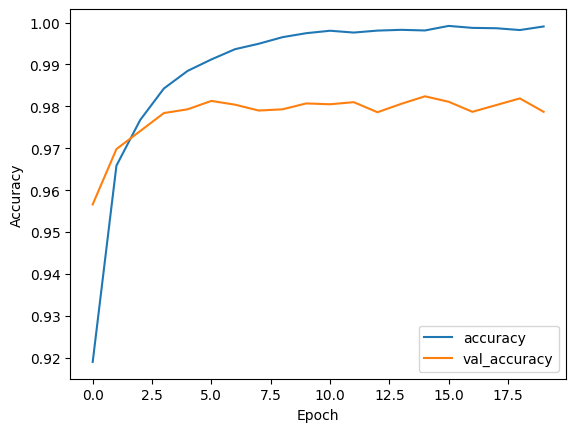

In [21]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [22]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.9786999821662903, 0.9985166788101196)